"""  #    
Bloque de introducción

"""  #

# Datasets
## Preparación
### Librerías

In [2]:
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

"""  #    
### Descarga
Preparamos una función genérica de descarga de los datasets y de su preparación.     
Esta nos permite escoger los atributos que usaremos asi como extraer a un variable aparte las clases en caso de estar disponibles.

"""  #


In [3]:
def load_dataset(dataset_url: str, attributes: dict, separator: str = '\s+', class_position: int = None):
    """Load a dataset from a specified url into a pandas DataFrame.

    :param str dataset_url: an url from a text based dataset
    :param dict attributes: attributes to keep in dictionary form:
        key: attribute position, value: attribute name
    :param str separator: file separator.
    :param int class_position: column index where classes are defined (starts by 0)
        if left empty (None), no prediction class will be used (intrinsic case).
    """
    # Load dataset as a pandas DataFrame from a specified url.
    dataset = pd.read_csv(dataset_url, sep=separator, header=None)

    # Add class index to the indexes to extract.
    if class_position is not None:
        attributes[class_position] = 'classes'

    # Keep only desired attributes and classes.
    dataset = dataset[attributes]

    # Force all values to be numeric.
    for (column, values) in dataset.iteritems():
        # Do not transform classes.
        if column == class_position:
            continue

        # Coerce transforms non-numeric values into NaN.
        dataset[column] = pd.to_numeric(values, errors='coerce')

    # Remove all NaN rows.
    dataset.dropna(inplace=True)

    # Extrinsic case, dataset comes with its classes.
    if class_position is not None:
        # Extract classes.
        classes = dataset[class_position]
        # Remove classes from attributes.
        dataset.drop(class_position, axis=1, inplace=True)

    # Intrinsic case, dataset has no classes.
    else:
        classes = None

    return classes, dataset


"""  #    
### Visualización
Usaremos una función común para presentar los datos, tanto como si están clasificados o no.    
También, en caso de usar más de dos atributos del dataset, usaremos el *pairplot* de seaborn para presentar los atributos de dos en dos.

"""  #


In [4]:
def plot_dataset(dataset: pd.DataFrame, classes: np.array = None) -> None:
    # For bi-dimensional dataset, use a simple plot.
    if len(dataset.columns) == 2:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(dataset.iloc[:, 0], dataset.iloc[:, 1], c=classes)

    # For extra-dimensional dataset compare attributes.
    else:
        if classes is not None:
            # Clone dataset to avoid modifying the original one.
            dataset = dataset.copy()
            dataset['classes'] = classes.astype(str)
            sns.pairplot(dataset, hue='classes')
        else:
            sns.pairplot(dataset)


## Métricas
### Métricas extrínsecas

In [5]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real == cats[i], cat_pred == clusts[j]))
                     for j in np.arange(clusts.size)]
                    for i in np.arange(cats.size)])
    return (mat)


In [6]:
def medida_error(mat):
    assign = np.sum([np.max(mat[l, :]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))


def medida_precision(mat, l, k):
    return mat[l, k] / sum(mat[:, k])


def medida_recall(mat, l, k):
    return mat[l, k] / sum(mat[l, :])


def medida_pureza(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    return np.sum([
        totales[k] * np.max(mat[:, k] / float(np.sum(mat[:, k])))
        for k in np.arange(mat.shape[1])
    ])


In [7]:
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec + rec) == 0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)


def medida_f1(mat):
    totales = np.sum(mat, axis=1) / float(np.sum(mat))
    assign = np.sum([
        totales[l] * np.max([
            medida_f1_especifica(mat, l, k)
            for k in np.arange(mat.shape[1])
        ])
        for l in np.arange(mat.shape[0])
    ])
    return assign


In [8]:
def medida_entropia(mat):
    totales = np.sum(mat, axis=0) / float(np.sum(mat))
    relMat = mat / np.sum(mat, axis=0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat == 0] = 0.0001  # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([
        totales[k] * np.sum([
            relMat[l, k] * logRelMat[l, k]
            for l in np.arange(mat.shape[0])
        ])
        for k in np.arange(mat.shape[1])
    ])


"""  #     
####  Agrupación métricas extrínsecas
La función a continuación nos permite generar un diccionario con todas las métricas intrínsecas y poder compararlas entre algoritmos.

"""  #


In [9]:
def calculate_extrinsic_metrics(real_classes, predicted_classes):
    confusion_matrix = matriz_confusion(real_classes, predicted_classes)

    return {
        'Error': medida_error(confusion_matrix),
        'Pureza': medida_pureza(confusion_matrix),
        'F1': medida_f1(confusion_matrix),
        'Entropía': medida_entropia(confusion_matrix),
        'Información mútua': metrics.mutual_info_score(real_classes, predicted_classes)
    }


"""  #    
### Métricas intrínsecas
Añadimos las funciones de cálculo de métricas intrínsecas no disponibiles directamente en python o por lo menso en sklearn.

"""  #


In [10]:
def RMSSTD_score(dataset, prediction, centers):
    # Extract all individual predicted classes.
    labels = np.unique(prediction)

    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centers[label], axis=1) ** 2)
        for label in labels
    ])

    denominator = dataset.shape[1] * np.sum([
        np.sum(prediction == label) - 1
        for label in labels
    ])

    return np.sqrt(numerator / denominator)


In [11]:
def r2_score(dataset, prediction, centroids):
    """
    An intrinsic R² score metric, as sklearn one is extrinsic only.
    """
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    numerator = np.sum([
        np.sum(np.sum(dataset[prediction == label] - centroids[label], axis=1) ** 2)
        for label in labels
    ])
    denominator = np.sum(np.sum(dataset - attributes_mean, 1) ** 2)

    return 1 - numerator / denominator


In [12]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x - y) ** 2))


def distance_matrix(X, distancia):
    mD = np.zeros((X.shape[0], X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0], :], X[pair[1], :])
    return mD


def medida_I(dataset, prediction, centers, distance_function, p=1):
    attributes_mean = np.mean(dataset, axis=0)
    labels = np.sort(np.unique(prediction))
    distance_max = np.max(distance_matrix(centers, distance_function))

    num = np.sum([distance_function(instance, attributes_mean) for instance in dataset.values])

    den = len(labels) * np.sum([
        np.sum([
            distance_function(dataset.iloc[i], centers[k])
            for i in np.arange(dataset.shape[0])[prediction == labels[k]]
        ])
        for k in np.arange(centers.shape[0])
    ])

    return (num / den * distance_max) ** p


"""  #    
####  Agrupación métricas intrínsecas
La función a continuación nos permite generar un diccionario con todas las métricas intrínsecas y poder compararlas entre algoritmos.

"""  #


In [13]:
def calculate_intrinsic_metrics(dataset, prediction):
    return {
        # 'RMSSTD': RMSSTD_score(dataset, model['prediction'], model['centers']),
        # 'R²': r2_score(dataset, model['prediction'], model['centers']),
        'Silueta': metrics.silhouette_score(dataset, prediction),
        'Calinski Harabasz': metrics.calinski_harabasz_score(dataset, prediction),
        # 'Medida I': medida_I(dataset, model['prediction'], model['centers'], distancia),
        'Davies Bouldin': metrics.davies_bouldin_score(dataset, prediction)
    }


## Selección

"""  #    
### Dataset extrínseca
   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumption in miles per gallon,
    to be predicted in terms of 3 multivalued discrete and 5 continuous
    attributes." (Quinlan, 1993)

**Number of Instances:** 398

**Number of Attributes:** 9 including the class attribute

**Attribute Information:**

    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

"""  #

In [14]:
# Cargamos el dataset.
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# attributes = {0: 'mpg', 2: 'displacement', 3: 'horsepower', 4: 'weight', 5: 'acceleration'}
attributes = {3: 'horsepower', 5: 'acceleration'}
extrinsic_classes, extrinsic_dataset = load_dataset(dataset_url, attributes, class_position=1)

# Soporte para las métricas
extrinsic_metrics = {}

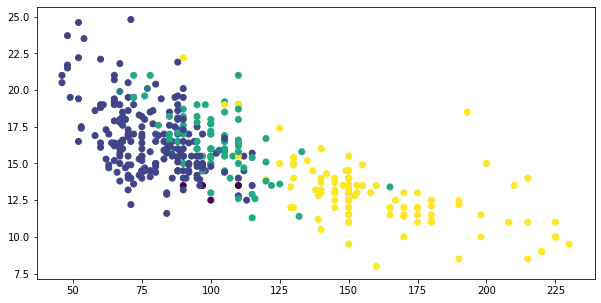

In [15]:
plot_dataset(extrinsic_dataset, extrinsic_classes)

"""  #    
blablabla

"""  #

"""  #    
## Dataset intrínseca
El dataset intrínseca **Aggregations** está generado de manera artificial por: *A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007*


Este dataset está compuesto por 788 observaciones de 2 variables que abarcan un amplio rango numérico. En el conjunto de datos existen entre 5 a 7 grupos que se distribuyen en zonas particulares del rango de valores de las variables.


Cargamos nuestro dataset (*intrinsic_dataset*):

"""  #

In [16]:
# Cargamos el dataset.
dataset_url = 'http://cs.joensuu.fi/sipu/datasets/Aggregation.txt'
attributes = {0: 'dim 1', 1: 'dim 2'}
_, intrinsic_dataset = load_dataset(dataset_url, attributes)

# Soporte para las métricas
intrinsic_metrics = {}

"""  #    
Visualizamos el dataset en 2-D.

"""  #

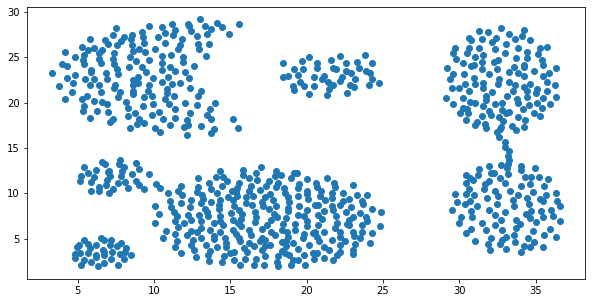

In [17]:
plot_dataset(intrinsic_dataset)

"""  #    
Destacamos que se podría clasificar con 4, 5 o con 7 clusters.

"""  #

"""  #    
# Algoritmos
Preparamos funciones 'herramienta' para cada algoritmo de forma a poder analizarlos.

"""  #

## K-Means

"""  #    
Métrica R cadrado. No usamos directamente la de sklean al esta necesitar la clases reales.
Nos permite valorar el ratio de distancia intraclúster con respecto a la distancia interclúster.

"""  #

"""  #    
Función para generar gráficamente la evolución de las métricas R² y Silueta según el número de cluters, de forma a escoger el número de clusters óptimo, usando la técnica del codo.

"""  #


In [18]:
def kmeans_plot_clusters_selection(dataset: pd.DataFrame, max_clusters: int = 10):
    dataset = np.array(dataset)
    silhouette_values = []
    r2_values = []
    min_clusters = 2

    for k in np.arange(min_clusters, max_clusters):
        model = KMeans(n_clusters=k).fit(dataset)
        prediction = model.predict(dataset)
        centroids = model.cluster_centers_

        silhouette_values += [metrics.silhouette_score(dataset, prediction)]
        r2_values += [r2_score(dataset, prediction, centroids)]

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.arange(min_clusters, max_clusters), silhouette_values, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot(np.arange(min_clusters, max_clusters), r2_values, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")


# Análisis dataset extrínseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

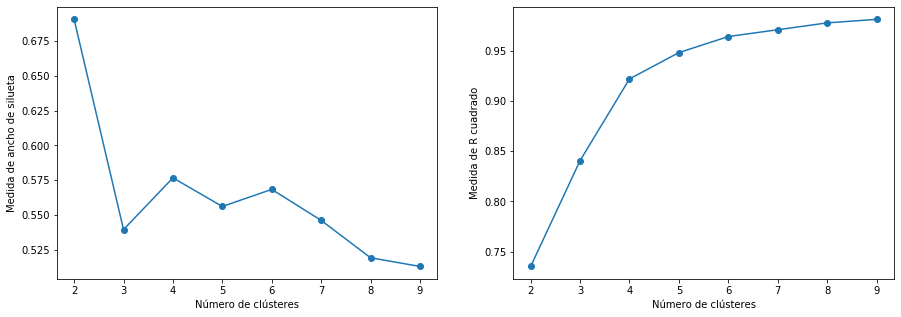

In [19]:
kmeans_plot_clusters_selection(extrinsic_dataset)

"""  #    
Vemos un "codo" pronunciando con 4 clusters, pero el ancho de silueta es "mínimo" a partir de 6 clusters.     
Escogemos 5 clusters como punto intermedio.

"""  #

#### Ejecución del algoritmo

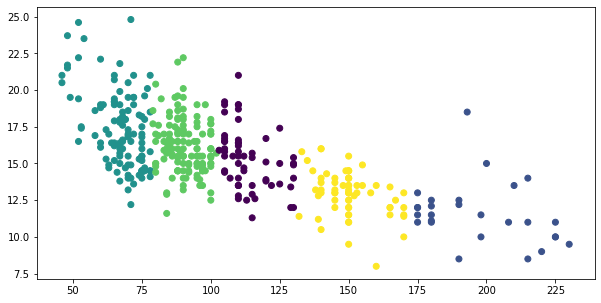

In [20]:
model = KMeans(n_clusters=5).fit(extrinsic_dataset)
prediction = model.predict(extrinsic_dataset)
extrinsic_metrics['k-means'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

plot_dataset(extrinsic_dataset, prediction)

"""  #     
blablabla

"""  #

### Algoritmo Jerárquico Aglomerativo
#### Ejecución del algoritmo

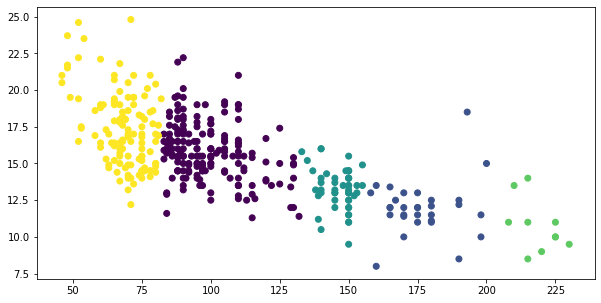

In [21]:
# Generamos el modelo.
model = linkage(extrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=5).flatten()
# Guardamos la métricas.
extrinsic_metrics['Jerárquico'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algoritmo Agrupamiento espectral

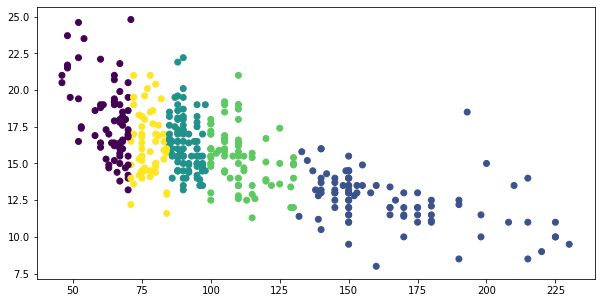

In [22]:
K = 5
knn = 50

# Generamos el modelo.
model = SpectralClustering(
    n_clusters=K, affinity='nearest_neighbors', n_neighbors=knn, random_state=0
).fit(extrinsic_dataset)
prediction = model.labels_

# Guardamos la métricas.
extrinsic_metrics['Espectral'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algoritmo Mean Shift

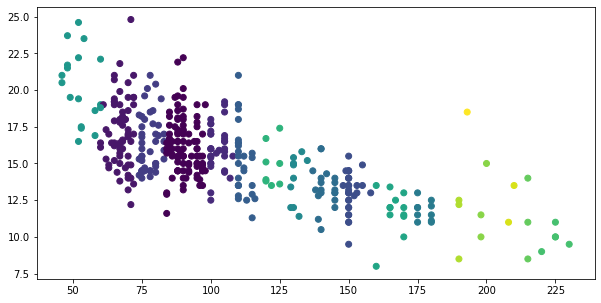

In [23]:
h = 6

# Generamos el modelo.
model = MeanShift(bandwidth=h).fit(extrinsic_dataset)
prediction = model.labels_

# Guardamos la métricas.
extrinsic_metrics['Means-Shift'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Algritmo EM

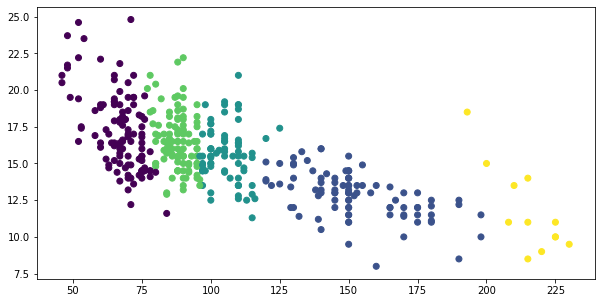

In [24]:
# Generamos el modelo.
model = GaussianMixture(n_components=5, max_iter=1000).fit(extrinsic_dataset)
prediction = model.predict(extrinsic_dataset)

# Guardamos la métricas.
extrinsic_metrics['EM'] = calculate_extrinsic_metrics(extrinsic_classes, prediction)

# Presentamos los clusters.
plot_dataset(extrinsic_dataset, prediction)

### Comparación algoritmos

In [25]:
display(pd.DataFrame(extrinsic_metrics))

,k-means,Jerárquico,Espectral,Means-Shift,EM
Error,0.456633,0.372449,0.464286,0.670918,0.382653
Pureza,0.793367,0.732143,0.826531,0.844388,0.831633
F1,0.633502,0.655100,0.632971,0.450004,0.704816
Entropía,0.522776,0.580403,0.483197,0.431504,0.490271
Información mútua,0.585349,0.527722,0.624928,0.676622,0.617854


"""  #    
blabla comparación dataset extrinseca

"""  #

# Análisis dataset intrínseca
## Algoritmos

"""  #    
### Algoritmo k-means
#### Selección del número de clusters

A fin de implementar el modelo de K-Medios, comencemos por determinar la cantidad óptima de centroides a utilizar a partir del Método del Codo.

"""  #

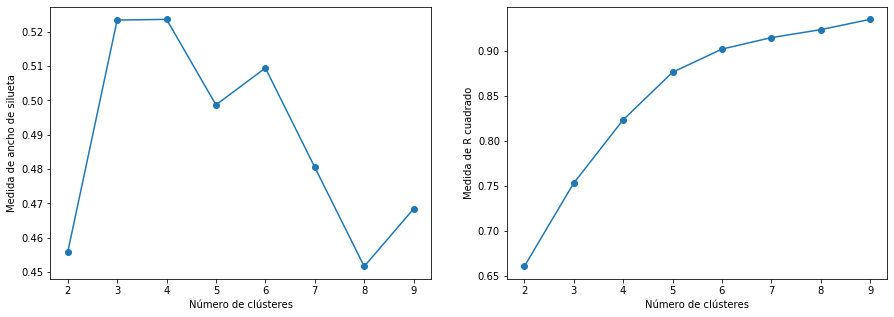

In [26]:
kmeans_plot_clusters_selection(intrinsic_dataset)

"""  #    
Según el procedimiento del codo, escogeríamos entre 5 y 7 clusters

"""  #

"""  #
#### Ejecución del algoritmo
Ejecutamos la predicción de k-means con 5 clusters y visualizamos la agrupación generada.


"""  #

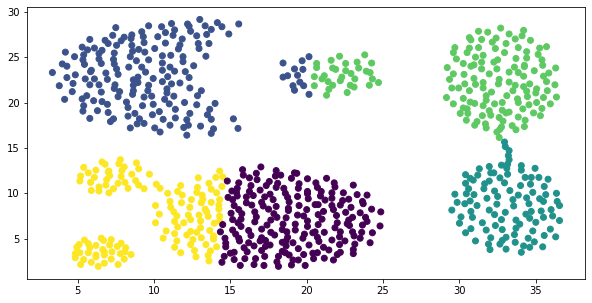

In [27]:
# Generamos el modelo.
model = KMeans(n_clusters=5).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)

# Guardamos la métricas.
intrinsic_metrics['k-means'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

# Presentamos los clusters.
plot_dataset(intrinsic_dataset, prediction)

"""  #    
Vemos que mientras se han logrado aislar algunos grupos, otros claramente se han quedado a medias.

"""  #

### Algoritmo Jerárquico Aglomerativo

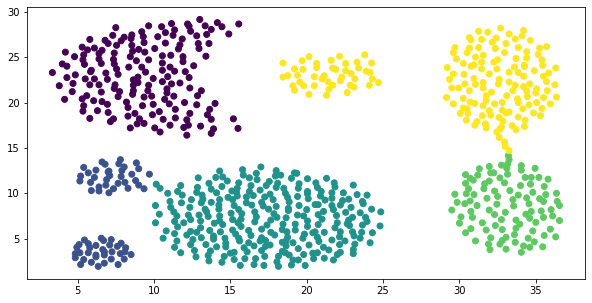

In [28]:
model = linkage(intrinsic_dataset, 'average')
prediction = cut_tree(model, n_clusters=5).flatten()
intrinsic_metrics['Jerárquico'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

### Algoritmo Agrupamiento espectral

/opt/anaconda/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


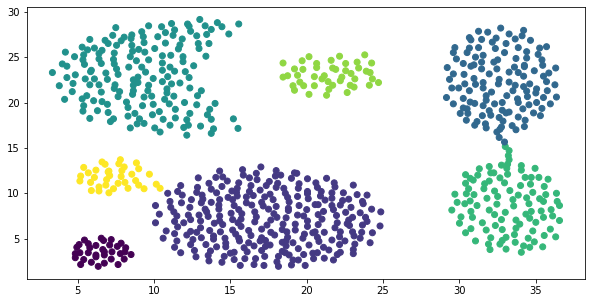

In [29]:
K = 7
knn = 30
model = SpectralClustering(
    n_clusters=K, affinity='nearest_neighbors', n_neighbors=knn, random_state=0
).fit(intrinsic_dataset)
prediction = model.labels_
intrinsic_metrics['Espectral'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
El jerarquico con 30 KNN resuelve bien la clusterización con 7 grupos, si se reduce no lo hace tan bien, y  partir de 50 tampoco. Hay que encontar el valor correcto.    
Buscando 5 clusters tambien lo hace bien.

"""  #

### Algoritmo Mean Shift

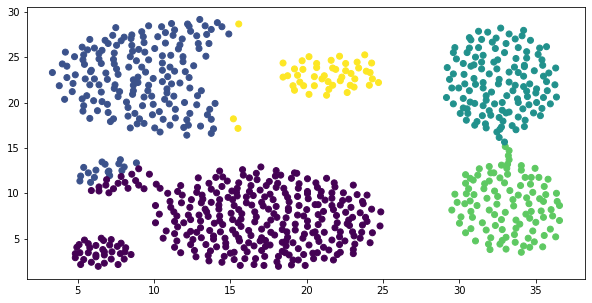

In [30]:
h = 6
model = MeanShift(bandwidth=h).fit(intrinsic_dataset)
prediction = model.labels_
intrinsic_metrics['Means-Shift'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

### Algoritmo EM

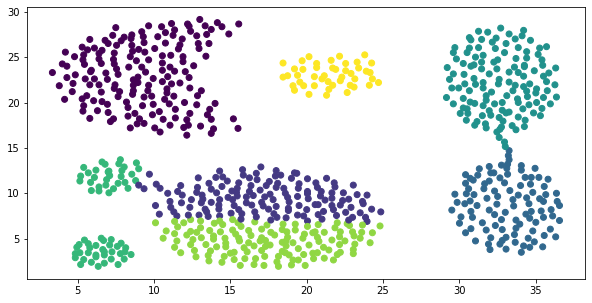

In [31]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=7, max_iter=1000).fit(intrinsic_dataset)
prediction = model.predict(intrinsic_dataset)
intrinsic_metrics['EM'] = calculate_intrinsic_metrics(intrinsic_dataset, prediction)

plot_dataset(intrinsic_dataset, prediction)

"""  #    
Este a veces la clava y a veces no. Hay que darle varias veces. Es curioso.

"""  #

### Comparación algoritmos

In [32]:
display(pd.DataFrame(intrinsic_metrics))

,k-means,Jerárquico,Espectral,Means-Shift,EM
Silueta,0.498806,0.500799,0.495429,0.520544,0.458649
Calinski Harabasz,1326.072670,1208.002199,1214.675898,1081.305595,1226.507973
Davies Bouldin,0.704130,0.682380,0.506748,0.556957,0.830024


"""  #     
blabla comparación dataset intrinseco

"""  #

# Conclusión